# DC magnetometry 

In this tutorial, the Ubermag micromagnetic simulation software is used to create a 3-dimensional magnetic structure, on which DC magnetometry can be performed. DC magnetometry is a measurement technique that enables the magnetic dipole moment of a sample to be measured. Magnetometers come in many varieties, such as Vibrating Sample Magnetometers and Superconducting Quantum Interference Device magnetometers, but these all have the ability to measure the sample's magnetisation.

## Magnetometry Reference frame
In `mag2exp` the experimental reference for magnetometry is defined to be congruent to the sample reference frame.

## The micromagnetic simulation
A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-dimensional magnetic structure.

In [1]:
%matplotlib inline
import discretisedfield as df
import matplotlib.pyplot as plt
import micromagneticmodel as mm
import numpy as np
import oommfc as oc

np.random.seed(1)

region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name="DC")

system.energy = (
    mm.Exchange(A=1.6e-11) + mm.DMI(D=4e-3, crystalclass="T") + mm.Zeeman(H=(0, 0, 0))
)

Ms = 1.1e6  # A/m


def m_fun(pos):
    return 2 * np.random.rand(3) - 1


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)

Plot the initial magnetisation:

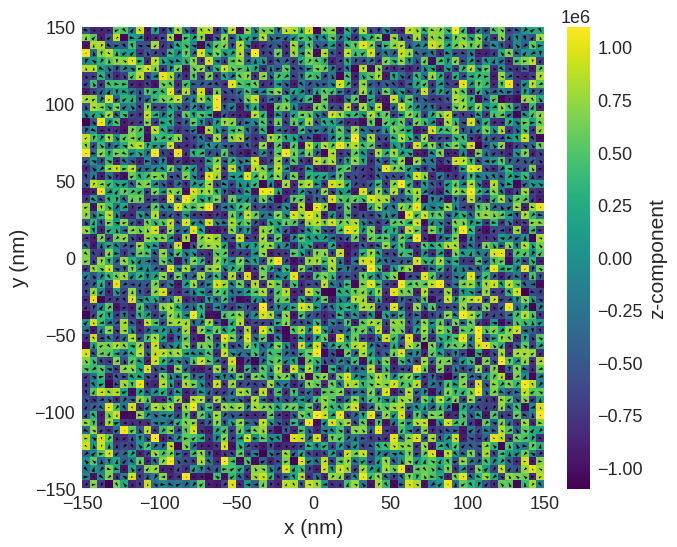

In [2]:
system.m.sel("z").mpl()

Relax the system and plot its magnetisation.

Running OOMMF (ExeOOMMFRunner)[2025-06-01T15:34:44]... (3.4 s)


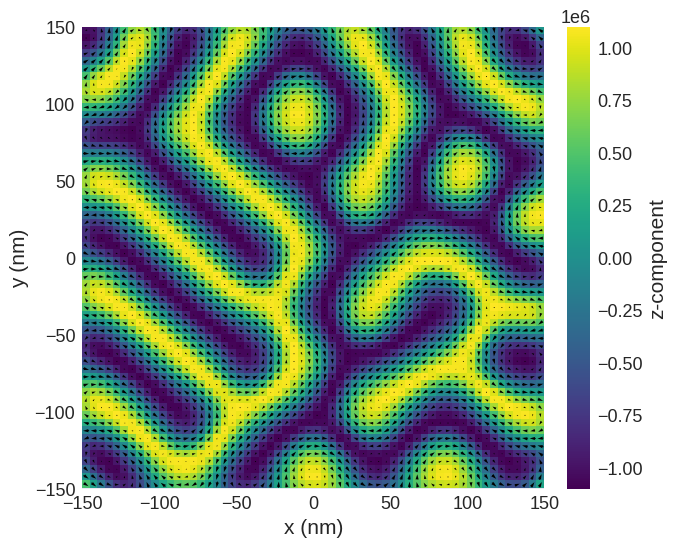

In [3]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

We can now compute the net magnetisation of the sample.

### DC Magnetisation

In [4]:
import mag2exp

The `mag2exp.magnetometry.magnetisation` function can be used to obtain the samples magnetisation in each dimension in A/m.

In [5]:
mag2exp.magnetometry.magnetisation(system.m)

array([  3518.07963722,   8389.3292641 , -25604.58073283])

We can set up a loop to mimic the experimental procedure of a magnetometer. We can apply an increasing field along $z$ direction and measure the magnetisation in this direction.

In [6]:
mag_arr = []
H_arr = []
for H in np.linspace(0, 1000000, 20):
    system.energy.zeeman.H = (0, 0, H)
    md.drive(system, verbose=0)
    H_arr.append(H)
    mag_arr.append(mag2exp.magnetometry.magnetisation(system.m))

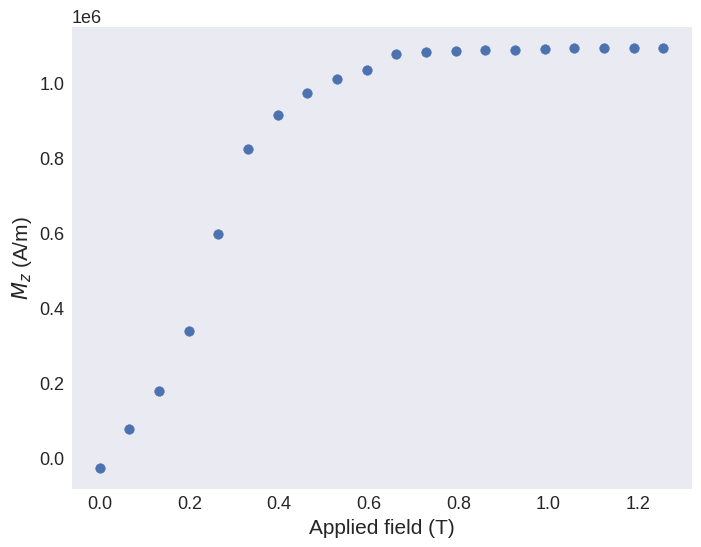

In [7]:
plt.scatter(np.array(H_arr) * 4 * np.pi * 1e-7, np.array(mag_arr)[:, 2])
plt.ylabel(r"$M_z$ (A/m)")
plt.xlabel("Applied field (T)")
plt.show()

This procedure can also be carried out using `oommfc.HysteresisDriver()`.